# PreMaskNet Bespoke Threshold Computation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-03-16 13:39:46.669231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model, get_path
from utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from neural_networks.model_diagnostics import ModelDiagnostics
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
import pickle
import itertools
import time
import datetime
import glob
import numpy as np
import gc

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load trained models

In [142]:
PROJECT_ROOT = Path.cwd().parent.resolve()

base_dir =  os.path.join(PROJECT_ROOT, "output_castle", "training_74_pre_mask_net_spars0.001") 
cfg = os.path.join(base_dir, "cfg_pre_mask_net.yml")


In [130]:
def get_setup(setup_file):
    setup = SetupDiagnostics(["-c", setup_file])
    return setup

In [76]:
def get_models(setup_file):
    setup = get_setup(setup_file)
    model_key = setup.nn_type
    
    models = load_models(setup)
    return models[model_key]

## Load models to get masking vectors

In [10]:
models = get_models(cfg)


Set leaky relu alpha to 0.3


Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_77_pre_mask_net_spars1.0/models/PreMaskNet/lspar1.0/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU_0.3-e_9/1_0_model.keras


Lambda sparsity = 1.0


Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_77_pre_mask_net_spars1.0/models/PreMaskNet/lspar1.0/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU_0.3-e_9/1_1_model.keras


Lambda sparsity = 1.0


Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_77_pre_mask_net_spars1.0/models/PreMaskNet/lspar1.0/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU_0.3-e_9/1_2_model.keras


Lambda sparsity = 1.0


Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_77_pre_mask_net_spars1.0/models/PreMaskNet/lspar1.0/hl_256_2

In [11]:
models.keys()

dict_keys(['tphystnd-3.64', 'tphystnd-7.59', 'tphystnd-14.36', 'tphystnd-24.61', 'tphystnd-38.27', 'tphystnd-54.6', 'tphystnd-72.01', 'tphystnd-87.82', 'tphystnd-103.32', 'tphystnd-121.55', 'tphystnd-142.99', 'tphystnd-168.23', 'tphystnd-197.91', 'tphystnd-232.83', 'tphystnd-273.91', 'tphystnd-322.24', 'tphystnd-379.1', 'tphystnd-445.99', 'tphystnd-524.69', 'tphystnd-609.78', 'tphystnd-691.39', 'tphystnd-763.4', 'tphystnd-820.86', 'tphystnd-859.53', 'tphystnd-887.02', 'tphystnd-912.64', 'tphystnd-936.2', 'tphystnd-957.49', 'tphystnd-976.33', 'tphystnd-992.56', 'phq-3.64', 'phq-7.59', 'phq-14.36', 'phq-24.61', 'phq-38.27', 'phq-54.6', 'phq-72.01', 'phq-87.82', 'phq-103.32', 'phq-121.55', 'phq-142.99', 'phq-168.23', 'phq-197.91', 'phq-232.83', 'phq-273.91', 'phq-322.24', 'phq-379.1', 'phq-445.99', 'phq-524.69', 'phq-609.78', 'phq-691.39', 'phq-763.4', 'phq-820.86', 'phq-859.53', 'phq-887.02', 'phq-912.64', 'phq-936.2', 'phq-957.49', 'phq-976.33', 'phq-992.56', 'fsnt', 'fsns', 'flnt', 'fl

In [13]:
masking_vector_per_var = dict()

for var, (model, inputs) in models.items():
    input_layer_weight = model.input_layer.trainable_variables[0].numpy()
    masking_vector = np.linalg.norm(input_layer_weight, ord=2, axis=1)

    masking_vector_per_var[var] = masking_vector


## Load masking vectors directly

In [99]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [143]:
output_vars = [var for var in generate_output_vars(get_setup(cfg))]


Set leaky relu alpha to 0.3



In [144]:
masking_vector_per_var = dict()
mv_dir = os.path.join(base_dir, "masking_vectors")

for var in output_vars:
    mv_filename = f"masking_vector_{var}.npy"

    masking_vector_per_var[var] = np.load(os.path.join(mv_dir, mv_filename))
    

## Get CausalSingleNN inputs

In [33]:
def get_causal_inputs():
    causal_nn_config = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6", 
                                    "cfg_causal_single_nn_diagnostics.yml")
    
    causal_nn_setup = get_setup(causal_nn_config)
    causal_nn_models = load_models(causal_nn_setup, skip_causal_phq=True)

    models = causal_nn_models[causal_nn_setup.nn_type][causal_nn_setup.pc_alphas[0]][causal_nn_setup.thresholds[0]]

    inputs = {var: inputs for var, (model, inputs) in models.items()}
    
    return inputs


In [34]:
causal_inputs_per_var = get_causal_inputs()


Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/models/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_0_model.h5

Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/models/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_1_model.h5

Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/models/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5

Load model: /p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/models_arch-rasp_thrs-opt-mse6/m

In [35]:
causal_inputs_per_var.keys()

dict_keys(['tphystnd-3.64', 'tphystnd-7.59', 'tphystnd-14.36', 'tphystnd-24.61', 'tphystnd-38.27', 'tphystnd-54.6', 'tphystnd-72.01', 'tphystnd-87.82', 'tphystnd-103.32', 'tphystnd-121.55', 'tphystnd-142.99', 'tphystnd-168.23', 'tphystnd-197.91', 'tphystnd-232.83', 'tphystnd-273.91', 'tphystnd-322.24', 'tphystnd-379.1', 'tphystnd-445.99', 'tphystnd-524.69', 'tphystnd-609.78', 'tphystnd-691.39', 'tphystnd-763.4', 'tphystnd-820.86', 'tphystnd-859.53', 'tphystnd-887.02', 'tphystnd-912.64', 'tphystnd-936.2', 'tphystnd-957.49', 'tphystnd-976.33', 'tphystnd-992.56', 'phq-14.36', 'phq-24.61', 'phq-38.27', 'phq-54.6', 'phq-72.01', 'phq-87.82', 'phq-103.32', 'phq-121.55', 'phq-142.99', 'phq-168.23', 'phq-197.91', 'phq-232.83', 'phq-273.91', 'phq-322.24', 'phq-379.1', 'phq-445.99', 'phq-524.69', 'phq-609.78', 'phq-691.39', 'phq-763.4', 'phq-820.86', 'phq-859.53', 'phq-887.02', 'phq-912.64', 'phq-936.2', 'phq-957.49', 'phq-976.33', 'phq-992.56', 'fsnt', 'fsns', 'flnt', 'flns', 'prect'])

## Test Thresholds

In [104]:

def get_best_threshold(masking_vector, causal_inputs):
    max_value = 0
    max_treshold = 0.0

    zeros = np.zeros_like(masking_vector, dtype=int)
    ones = np.ones_like(masking_vector, dtype=int)

    causal_vector = np.zeros(len(inputs), dtype=int)
    causal_vector[causal_inputs] = 1

    for t in thresholds:
        t = round(t, 4)
        t_vector = np.where(masking_vector < t, 
                            zeros, # value if condition true 
                            ones) # value if condition false
        


        comparison_sum = np.sum(t_vector == causal_vector) # the bigger the better
        
        if comparison_sum > max_value:
            max_value = comparison_sum
            max_treshold = t

    t_vector = np.where(masking_vector < max_treshold, 
                        zeros, # value if condition true 
                        ones) # value if condition false
    max_sum = np.sum(t_vector)

    causal_sum = np.sum(causal_vector)

    return max_treshold, max_sum, causal_sum
            
        

In [90]:
thresholds = np.arange(0.1, 2.0, step=0.05)

v = output_vars[20]
print(v)

masking_vector = masking_vector_per_var[v]
get_best_threshold(masking_vector, causal_inputs_per_var[v])

tphystnd-691.39


(0.8, 66, 67)

## Get bespoke tresholds

In [145]:
min_t = 1e-4
thresholds = np.arange(1e-4, 2.0, step=1e-4)
bespoke_thresholds = {}
max_sums_per_var = {}
causal_sums_per_var = {}

for var, masking_vector in masking_vector_per_var.items():
    if str(var) == "phq-3.64" or str(var) == "phq-7.59":
        max_sums_per_var[var] = 0
        causal_sums_per_var[var] = 0
        
        bespoke_thresholds[var] = min_t
        print(f"\nSetting min threshold={min_t} for variable {var}")
        continue

    best_t, max_sum, causal_sum = get_best_threshold(masking_vector, causal_inputs_per_var[var])

    print(f"\nBest threshold for variable {var}: {best_t} (max sum {max_sum} vs causal sum {causal_sum})")

    bespoke_thresholds[var] = best_t
    max_sums_per_var[var] = max_sum
    causal_sums_per_var[var] = causal_sum
    
    # print(f'\nSaving masking vector {Path(*Path(os.path.join(mv_dir, fn)).parts[-3:])}.')


Best threshold for variable tphystnd-3.64: 0.0001 (max sum 83 vs causal sum 86)

Best threshold for variable tphystnd-7.59: 0.0006 (max sum 82 vs causal sum 79)

Best threshold for variable tphystnd-14.36: 0.0001 (max sum 84 vs causal sum 94)

Best threshold for variable tphystnd-24.61: 0.0001 (max sum 84 vs causal sum 90)

Best threshold for variable tphystnd-38.27: 0.0001 (max sum 83 vs causal sum 91)

Best threshold for variable tphystnd-54.6: 0.0001 (max sum 83 vs causal sum 94)

Best threshold for variable tphystnd-72.01: 0.008 (max sum 69 vs causal sum 75)

Best threshold for variable tphystnd-87.82: 0.0713 (max sum 28 vs causal sum 49)

Best threshold for variable tphystnd-103.32: 0.101 (max sum 21 vs causal sum 27)

Best threshold for variable tphystnd-121.55: 0.2453 (max sum 15 vs causal sum 18)

Best threshold for variable tphystnd-142.99: 0.0625 (max sum 33 vs causal sum 40)

Best threshold for variable tphystnd-168.23: 0.271 (max sum 23 vs causal sum 24)

Best threshold fo

## Plot number of inputs

In [38]:
import matplotlib.pyplot as plt
import cmocean
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


Saving plot training_74_pre_mask_net_spars0.001/plots_offline_evaluation/thresholding/number_of_inputs_per_output_bespoke_tresholds.png.


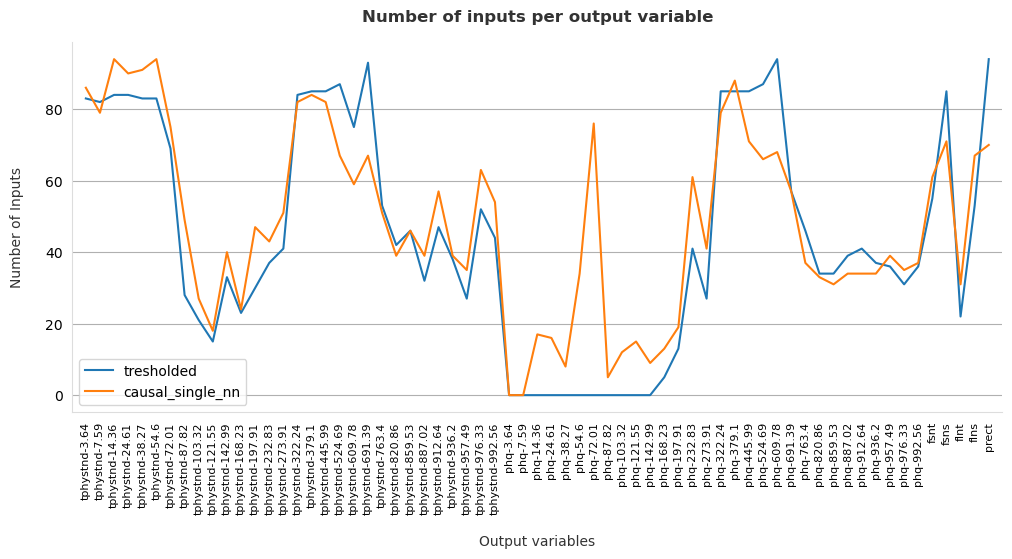

In [146]:
plt.close()
fig, ax = plt.subplots()
fig.set_figwidth(12)


x = range(len(output_vars))
sns.lineplot(x=x, y=max_sums_per_var.values(), label="tresholded", ax=ax)
sns.lineplot(x=x, y=causal_sums_per_var.values(), label="causal_single_nn", ax=ax)
plt.legend()

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.margins(x=0.015)

ax.set_xticks(range(len(output_vars)))
ax.set_xticklabels(output_vars, rotation=90, ha='center', va='top')
    
ax.set_xlabel('Output variables', labelpad=15, color='#333333')
ax.set_ylabel('Number of Inputs', labelpad=15, color='#333333')

ax.set_title('Number of inputs per output variable', pad=15, color='#333333', weight='bold', fontsize=12)

save_dir = os.path.join(base_dir, "plots_offline_evaluation", "thresholding")
Path(save_dir).mkdir(exist_ok=True, parents=True)
save_png = "number_of_inputs_per_output_bespoke_tresholds.png"
plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')

plt.show()

## Save Bespoke Thresholds

In [147]:
len(bespoke_thresholds.keys())

65

In [148]:
output_dir = os.path.join(base_dir, "bespoke_thresholds")
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(output_dir)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_74_pre_mask_net_spars0.001/bespoke_thresholds


In [149]:
with open(os.path.join(output_dir, "num_inputs_per_var.p"), "wb") as output_file:
    pickle.dump(max_sums_per_var, output_file)
print(f"Saved file {Path(*Path(os.path.join(output_dir, 'num_inputs_per_var.p')).parts[-4:])}")

Saved file output_castle/training_74_pre_mask_net_spars0.001/bespoke_thresholds/num_inputs_per_var.p


In [150]:
with open(os.path.join(output_dir, "thresholds_per_var.p"), "wb") as output_file:
    pickle.dump(bespoke_thresholds, output_file)
print(f"Saved file {Path(*Path(os.path.join(output_dir, 'thresholds_per_var.p')).parts[-4:])}")

Saved file output_castle/training_74_pre_mask_net_spars0.001/bespoke_thresholds/thresholds_per_var.p


In [48]:
output_dir = os.path.join(os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/"))
print(output_dir)
with open(os.path.join(output_dir, "num_inputs_per_var.p"), "wb") as output_file:
    pickle.dump(causal_sums_per_var, output_file)

/p/project/icon-a-ml/kuehbacher1/projects/iglesias-suarez2yxx_spuriouslinks/output_castle/eval_nando/causal_single_nn/


## Plot thresholds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Saving plot training_74_pre_mask_net_spars0.001/plots_offline_evaluation/thresholding/bespoke_threshold_per_output.png.


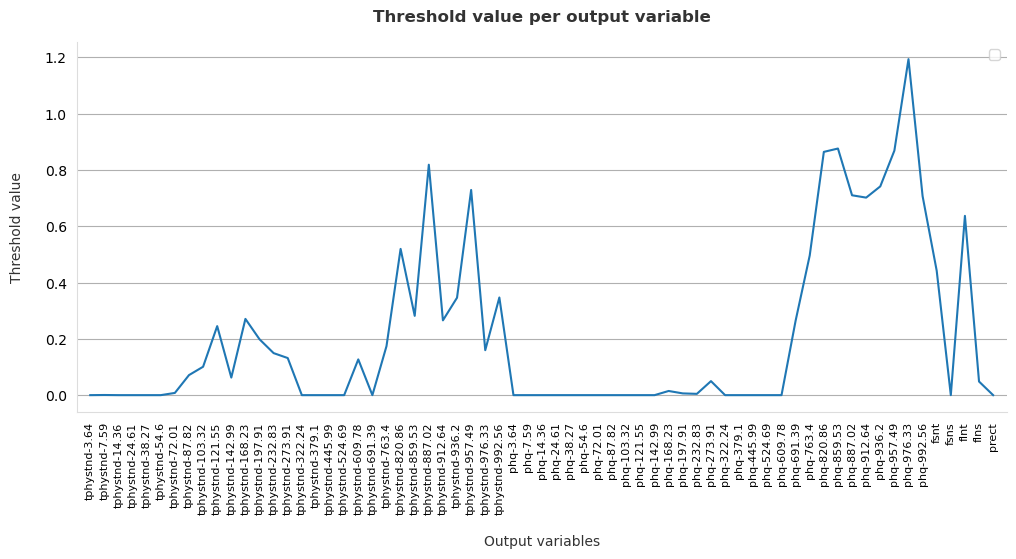

In [39]:
plt.close()
fig, ax = plt.subplots()
fig.set_figwidth(12)


x = range(len(bespoke_thresholds))
sns.lineplot(x=x, y=bespoke_thresholds.values(), ax=ax)
plt.legend()

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.margins(x=0.015)

ax.set_xticks(range(len(bespoke_thresholds)))
ax.set_xticklabels([str(var) for var in bespoke_thresholds.keys()], rotation=90, ha='center', va='top')
    
ax.set_xlabel('Output variables', labelpad=15, color='#333333')
ax.set_ylabel('Threshold value', labelpad=15, color='#333333')

ax.set_title('Threshold value per output variable', pad=15, color='#333333', weight='bold', fontsize=12)


save_dir = os.path.join(base_dir, "plots_offline_evaluation", "thresholding")
Path(save_dir).mkdir(exist_ok=True, parents=True)
save_png = "bespoke_threshold_per_output.png"
plt.savefig(os.path.join(save_dir, save_png), dpi=400, bbox_inches="tight")
print(f'\nSaving plot {Path(*Path(os.path.join(save_dir, save_png)).parts[-4:])}.')

plt.show()

## Load bespoke thresholds

In [40]:
with open(os.path.join(output_dir, "thresholds_per_var.p"), "rb") as read_file:
    bespoke_thresholds = pickle.load(read_file)

In [41]:
bespoke_thresholds

{'tphystnd-3.64': 0.0001,
 'tphystnd-7.59': 0.0006000000000000001,
 'tphystnd-14.36': 0.0001,
 'tphystnd-24.61': 0.0001,
 'tphystnd-38.27': 0.0001,
 'tphystnd-54.6': 0.0001,
 'tphystnd-72.01': 0.008,
 'tphystnd-87.82': 0.0713,
 'tphystnd-103.32': 0.101,
 'tphystnd-121.55': 0.2453,
 'tphystnd-142.99': 0.0625,
 'tphystnd-168.23': 0.271,
 'tphystnd-197.91': 0.1986,
 'tphystnd-232.83': 0.1494,
 'tphystnd-273.91': 0.1319,
 'tphystnd-322.24': 0.0001,
 'tphystnd-379.1': 0.0001,
 'tphystnd-445.99': 0.0001,
 'tphystnd-524.69': 0.0001,
 'tphystnd-609.78': 0.1271,
 'tphystnd-691.39': 0.0001,
 'tphystnd-763.4': 0.1742,
 'tphystnd-820.86': 0.5198,
 'tphystnd-859.53': 0.2819,
 'tphystnd-887.02': 0.8188000000000001,
 'tphystnd-912.64': 0.2658,
 'tphystnd-936.2': 0.3463,
 'tphystnd-957.49': 0.7291,
 'tphystnd-976.33': 0.1598,
 'tphystnd-992.56': 0.3471,
 'phq-3.64': 0.0001,
 'phq-7.59': 0.0001,
 'phq-14.36': 0.0001,
 'phq-24.61': 0.0001,
 'phq-38.27': 0.0001,
 'phq-54.6': 0.0001,
 'phq-72.01': 0.0001,

In [87]:
np.round(0.38749739, 4)

0.3875